In [1]:
import numpy as np
import random
import cv2
import math
from scipy.stats import chi2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # This sets the Seaborn style

In [2]:
def SIFT_match(img1, des1, kp1, img2, des2, kp2):
    # Create a BFMatcher object
    bf = cv2.BFMatcher()

    # Match descriptors using KNN
    # means that for each descriptor in the first set (des1), the two best matches in the second set (des2) are returned.
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for NN1, NN2 in matches:
        ratio = NN1.distance / NN2.distance
        threshold = 0.8
        if ratio < threshold:
            good_matches.append(NN1)
            
    # Draw good matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return img_matches, good_matches

def detect_sift_keypoints(image):
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image_gray,None)

    # image_with_keypoints =cv2.drawKeypoints(image_gray,kp,image)
    image_with_keypoints =cv2.drawKeypoints(image_gray,kp,image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return kp, des, image_with_keypoints

In [3]:
def computeHomography(features, matches, model):
    '''
        features: points from the input image (xi, yi)
        matches: points from the output image(xi', yi')
    '''
    # validate the model
    assert model in ['Euclidean', 'Similarity', 'Affine', 'Projective'], f'Model {model} doesn\'t exist within this implementation.'

    n_points = len(features)

    # defining the number of unknowns
    if model in ['Euclidean', 'Similarity']:
        n_unknowns = 4 # Euclidean without scale, Similarity with scale
        
    elif model == 'Affine':
        n_unknowns = 6

    elif model == 'Projective':
        n_unknowns = 8

    # creating template metrices
    A_mat = np.zeros((2*n_points, n_unknowns))
    x_mat = np.zeros((n_unknowns, 1))
    b_mat = np.zeros((2*n_points, 1))
    
    for index, (feature, match) in enumerate(zip(features, matches)):
        if model in ['Euclidean', 'Similarity']:
            A_values = np.array([[feature[0], -feature[1], 1, 0],
                                 [feature[1],  feature[0], 0, 1]])
            
        elif model == 'Affine':
            A_values = np.array([[feature[0], feature[1], 1, 0, 0, 0],
                                 [0, 0, 0, feature[0], feature[1], 1]])

        elif model == 'Projective':
            A_values = np.array([[feature[0], feature[1], 1, 0, 0, 0, -feature[0]*match[0], -feature[1]*match[0]],
                                 [0, 0, 0, feature[0], feature[1], 1, -feature[0]*match[1], -feature[1]*match[1]]])
        
        A_mat[2 * index:2 * index + 2, :] = A_values
        b_mat[2 * index] = match[0]
        b_mat[2 * index + 1] = match[1]

    # solving using least-squares
    A_transpose_A_inv = np.linalg.inv(A_mat.T @ A_mat)
    A_transpose_b = A_mat.T @ b_mat
    x_mat = A_transpose_A_inv @ A_transpose_b

    # matrix reconstruction and reshaping
    if model in ['Euclidean', 'Similarity']:
        scos_theta = x_mat[0][0]
        ssin_theta = x_mat[1][0]
        
        theta = math.atan2(ssin_theta, scos_theta)

        # scale factor
        s = ssin_theta / (scos_theta * math.tan(theta))
        
        tx         = x_mat[2][0]
        ty         = x_mat[3][0]

        x_mat = np.array([[scos_theta, -ssin_theta, tx],
                          [ssin_theta,  scos_theta, ty],
                          [0, 0, 1]])

        if model == 'Euclidean':
            # remove the scale from the 2x2 matrix
            x_mat[:2, :2] /= s
        
    elif model == 'Affine':
        x_mat = x_mat.reshape((2, 3))
        x_mat = np.vstack([x_mat, [0, 0, 1]])

    elif model == 'Projective':
        x_mat = np.vstack([x_mat, [1]]).reshape((3, 3))

    return x_mat

In [4]:
def warp_image(img, homography):
    '''
    The calculated homography can be used to warp
    the source image to destination. Size is the
    size (width,height) of im_dst
    '''

    # Warp source image to destination based on homography
    im_out = cv2.warpPerspective(img, homography, (img.shape[1],img.shape[0]))

    return im_out

In [5]:
def show_image_and_modified(img1, img2, title1, title2):
    # Set a larger figure size
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)) 
    plt.title(title1)
    plt.axis('off')


    # Display the modified image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) 
    plt.title(title2)
    plt.axis('off')

    # Show the plot
    plt.show()   


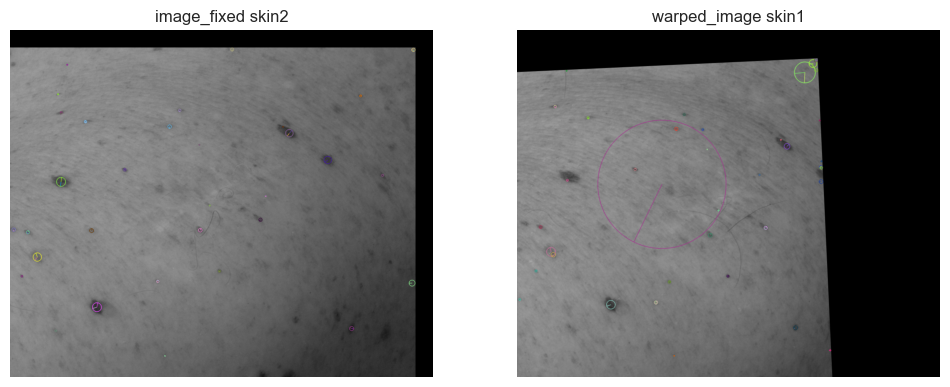

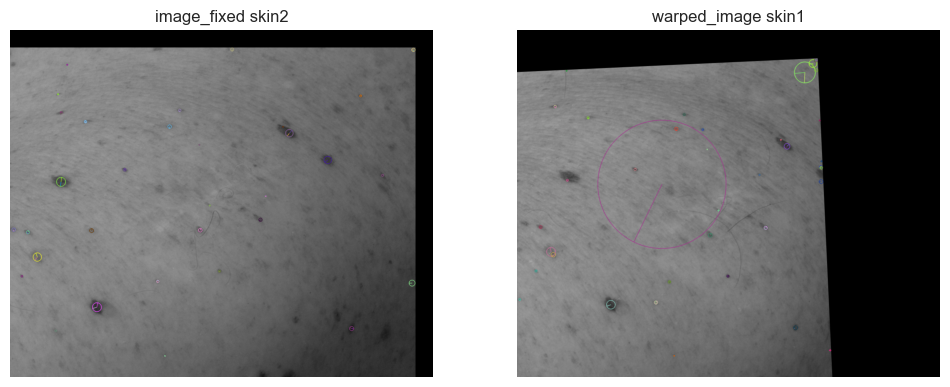

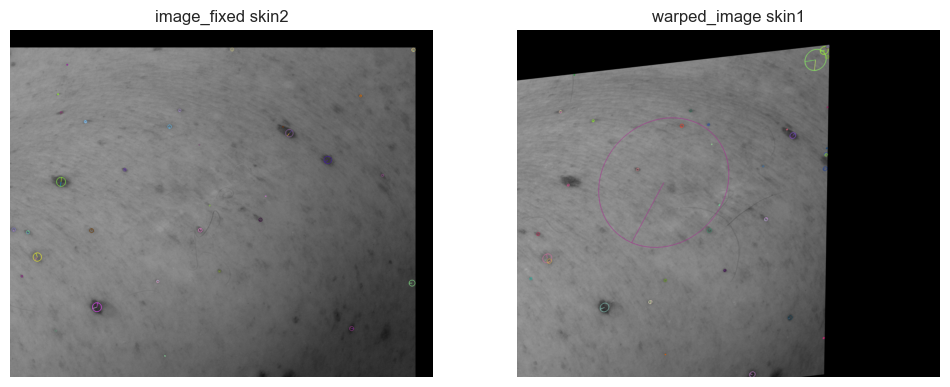

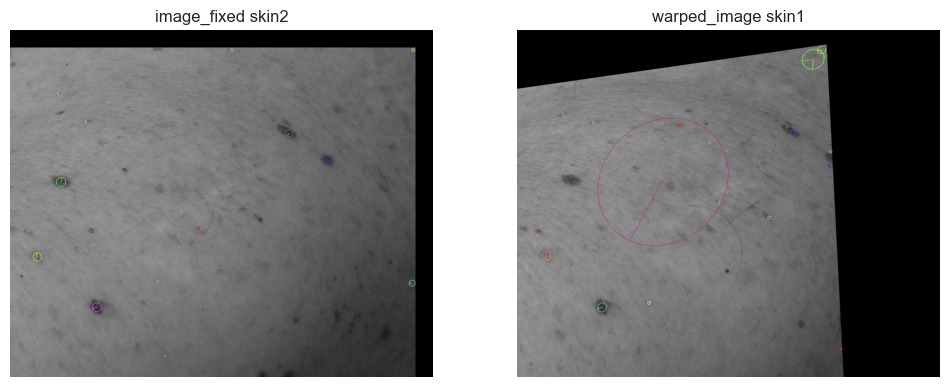

In [6]:
image_fixed  = cv2.imread(f"./Lab3_data/skin2.png")
image_moving = cv2.imread(f"./Lab3_data/skin1.png")

kp1, des1, image_with_keypoints1 = detect_sift_keypoints(image_fixed)
kp2, des2, image_with_keypoints2 = detect_sift_keypoints(image_moving)

img_matches, good_matches = SIFT_match(
    img1 = image_fixed,
    des1 = des1,
    kp1  = kp1,
    img2 = image_moving, 
    des2 = des2,
    kp2  = kp2
)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# reformat them to work on our implementation
src_pts = [[point[0][0], point[0][1]] for point in src_pts]
dst_pts = [[point[0][0], point[0][1]] for point in dst_pts]

for model in ['Euclidean', 'Similarity', 'Affine', 'Projective']:
    homography_matrix = computeHomography(dst_pts, src_pts, model=model)
    warped_image = warp_image(image_moving, homography_matrix)

    show_image_and_modified(image_fixed, warped_image, f"image_fixed skin2", f"warped_image skin1")

In [7]:
def computeReprojectionError(homography, feature, match):
    xI1 = feature # X
    xI2 = match   # X'
    H   = homography

    # inverse of homography matrix
    H_inverse = np.linalg.inv(H)

    # dividing all the elements of the inverse of H	by the element 3,3 of the inverse of H
    H_prime = H_inverse/H_inverse[2, 2]

    # reprojection error
    R = []

    # the reprojection error can be defined as the error of projecting X into image I' and subtracting X' added to the error in the other direction
    # i.e. the error of projecting X' into image I and subtracting X
    for f, m in zip(xI1, xI2):
        # print(f,m) [309.1516, 447.09436] [45.727722, 520.5462]
        eqn1 = ((H[0,0]*m[0]) + (H[0,1]*m[1]) + H[0,2])/((H[2,0]*m[0]) + (H[2,1]*m[1]) + 1)
        eqn2 = ((H[1,0]*m[0]) + (H[1,1]*m[1]) + H[1,2])/((H[2,0]*m[0]) + (H[2,1]*m[1]) + 1)
        eqn3 = ((H_prime[0,0]*f[0]) + (H_prime[0,1]*f[1]) + H_prime[0,2])/((H_prime[2,0]*f[0]) + (H_prime[2,1]*f[1]) + 1)
        eqn4 = ((H_prime[1,0]*f[0]) + (H_prime[1,1]*f[1]) + H_prime[1,2])/((H_prime[2,0]*f[0]) + (H_prime[2,1]*f[1]) + 1)

        r = np.array([[f[0] - eqn1],
                      [f[1] - eqn2],
                      [m[0] - eqn3],
                      [m[1] - eqn4]])
        R.append(r)
    
    # Convert the list of arrays to a single Nx1 array
    R = np.vstack(R)
    R_transposed = R.T

    # compute the error
    reprojection_error = R_transposed @ R

    # normalized error
    normalized_error = reprojection_error / len(R)

    return normalized_error

In [8]:
def computeHomographyRANSAC(features, matches, model, ransac_params):
    """
    Compute homography matrix using RANSAC for robust estimation.

    Parameters:
    - features: Points from the input image (xi, yi).
    - matches: Points from the output image (xi', yi').
    - model: Model type ('Euclidean', 'Similarity', 'Affine', 'Projective').
    - ransac_params: Parameters for the RANSAC algorithm (s, k, t, d).

    Returns:
    - best_homography: The homography matrix estimated with RANSAC.
    - best_inliers: Indices of the best inliers.
    """
    best_homography = None
    best_inliers = []

    # Prepare data for RANSAC
    data = list(zip(features, matches)) # len(features) x features.shape[1] x features.shape[1]

    # ransac params
    s, k, t, d = ransac_params[0], ransac_params[1], ransac_params[2], ransac_params[3]

    for _ in range(k):
        # Randomly select s data points to form a potential model
        sample_indices = np.random.choice(len(data), s, replace=False)
        sample = np.array(data)[sample_indices]

        # restructure the data to fit our model algorithm
        features_sample, matches_sample = zip(*sample)

        # fit the model
        sample_homography = computeHomography(features_sample, matches_sample, model) # 3x3 shape
        
        # Count inliers
        inliers = []
        for i in range(len(data)):
            # Compute the reprojection error
            reprojection_error = computeReprojectionError(sample_homography, features, matches)
            # reprojection_error = computeReprojectionError(sample_homography, [features[i]], [matches[i]])
            
            # Check if it's an inlier
            if reprojection_error[0][0] < t:
                inliers.append(i)

        # If the current model is better, update the best model
        if len(inliers) >= d and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_homography = sample_homography
                
    return best_homography, best_inliers

Best Homography: 
 [[ 1.00641787e+00  1.35305715e-01 -2.76686253e+02]
 [-1.35305715e-01  1.00641787e+00  1.23933980e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Best Inliers (Total=16):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


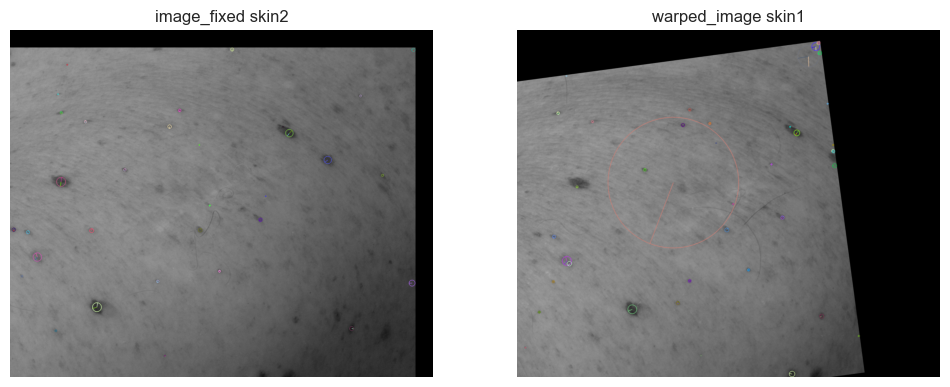

Best Homography: 
 [[ 9.63193982e-01  1.25279640e-01 -2.33546821e+02]
 [-1.25279640e-01  9.63193982e-01  1.25345392e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Best Inliers (Total=16):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


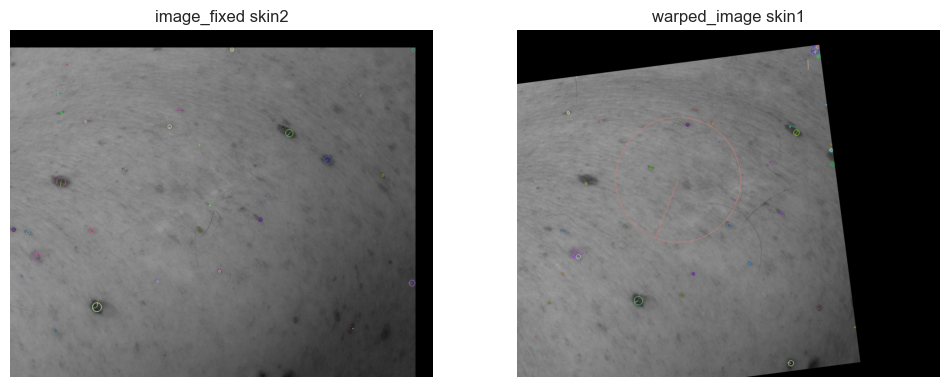

Best Homography: 
 [[ 1.16369833e+00 -8.74515656e-02 -2.76458930e+02]
 [-7.26904466e-02  9.82955941e-01  1.03614585e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Best Inliers (Total=16):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


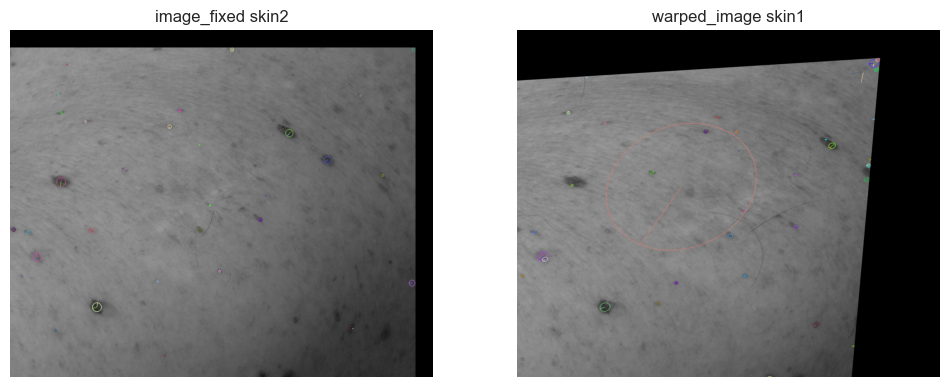

Best Homography: 
 [[ 8.95104336e-01 -3.21235324e-02 -2.08144283e+02]
 [-1.37561592e-01  8.75536901e-01  1.35664108e+02]
 [-7.48920956e-05 -9.40984756e-05  1.00000000e+00]]
Best Inliers (Total=16):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


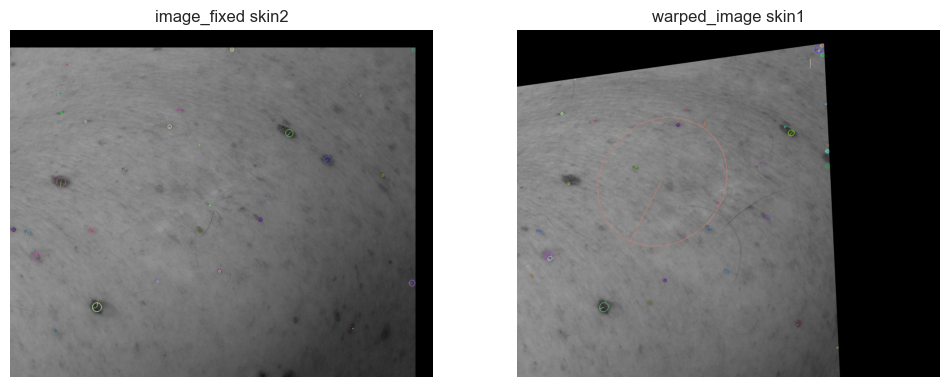

In [21]:
image_fixed  = cv2.imread(f"./Lab3_data/skin2.png")
image_moving = cv2.imread(f"./Lab3_data/skin1.png")

kp1, des1, image_with_keypoints1 = detect_sift_keypoints(image_fixed)
kp2, des2, image_with_keypoints2 = detect_sift_keypoints(image_moving)

img_matches, good_matches = SIFT_match(
    img1 = image_fixed,
    des1 = des1,
    kp1  = kp1,
    img2 = image_moving, 
    des2 = des2,
    kp2  = kp2
)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2) 

# reformat them to work on our implementation
src_pts = [[point[0][0], point[0][1]] for point in src_pts] # (16, 2)
dst_pts = [[point[0][0], point[0][1]] for point in dst_pts] # (16, 2)

for model in ['Euclidean', 'Similarity', 'Affine', 'Projective']:

    # compute ransac parameters
    '''RANSAC algorithm parameters are (s, k, t, d).
    
    - s: The minimum number of data values required to fit the model.
    - k: The maximum number of iterations allowed.
    - t: A threshold value for determining inliers.
    - d: The number of close data values required to assert that a model fits well to data.
    
    Note that we will assume that the proportion of the outliers is only 30% of the given data, thus
    '''

    if model in ['Euclidean', 'Similarity']:
        s = 2
        k = 7
        t = 131000
        d = 4
    elif model == 'Affine':
        s = 4
        k = 11
        t = 130000
        d = 6
    elif model == 'Projective':
        s = 4
        k = 17
        t = 131000
        d = 8

    ransac_params = (s, k, t, d)

    best_homography, best_inliers = computeHomographyRANSAC(dst_pts, src_pts, model, ransac_params)
    print('Best Homography: \n', best_homography)
    print(f'Best Inliers (Total={len(best_inliers)}): ', best_inliers)

    warped_image = warp_image(image_moving, best_homography)
    show_image_and_modified(image_fixed, warped_image, f"image_fixed skin2", f"warped_image skin1")
